In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import os
import cv2
import glob
import numpy as np

In [4]:
# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)

    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]

    return image

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(height, width)

In [5]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

In [6]:
# set the path
IMAGE_ROOT = "../data/test/DCM"
submission_path = '/data/ephemeral/home/hwang/results_deconvnet/submission.csv'

In [7]:
pngs = [
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
]

pngs1 = [x[6:] for x in pngs]

In [8]:
sub = pd.read_csv(submission_path)

In [10]:
# input the image name to check
imgname = 'ID211/image1663118048219.png'
idx = pngs.index(imgname)

In [11]:
image = cv2.imread('../data/test/DCM/{}'.format(pngs[idx]))

In [12]:
this = sub[sub['image_name']==pngs1[idx]]
nandf = this[this.rle.isna()]
nanlist = list(nandf['class'])

this = this.dropna(axis=0, subset='rle')

In [13]:
preds = []
for x in this['rle']:
    pred = decode_rle_to_mask(x, height=2048, width=2048)
    preds.append(pred)
    
preds = np.stack(preds, 0)

In [14]:
def text_coord(idx):
    x = idx % 2048
    y = idx // 2048
    return x, y

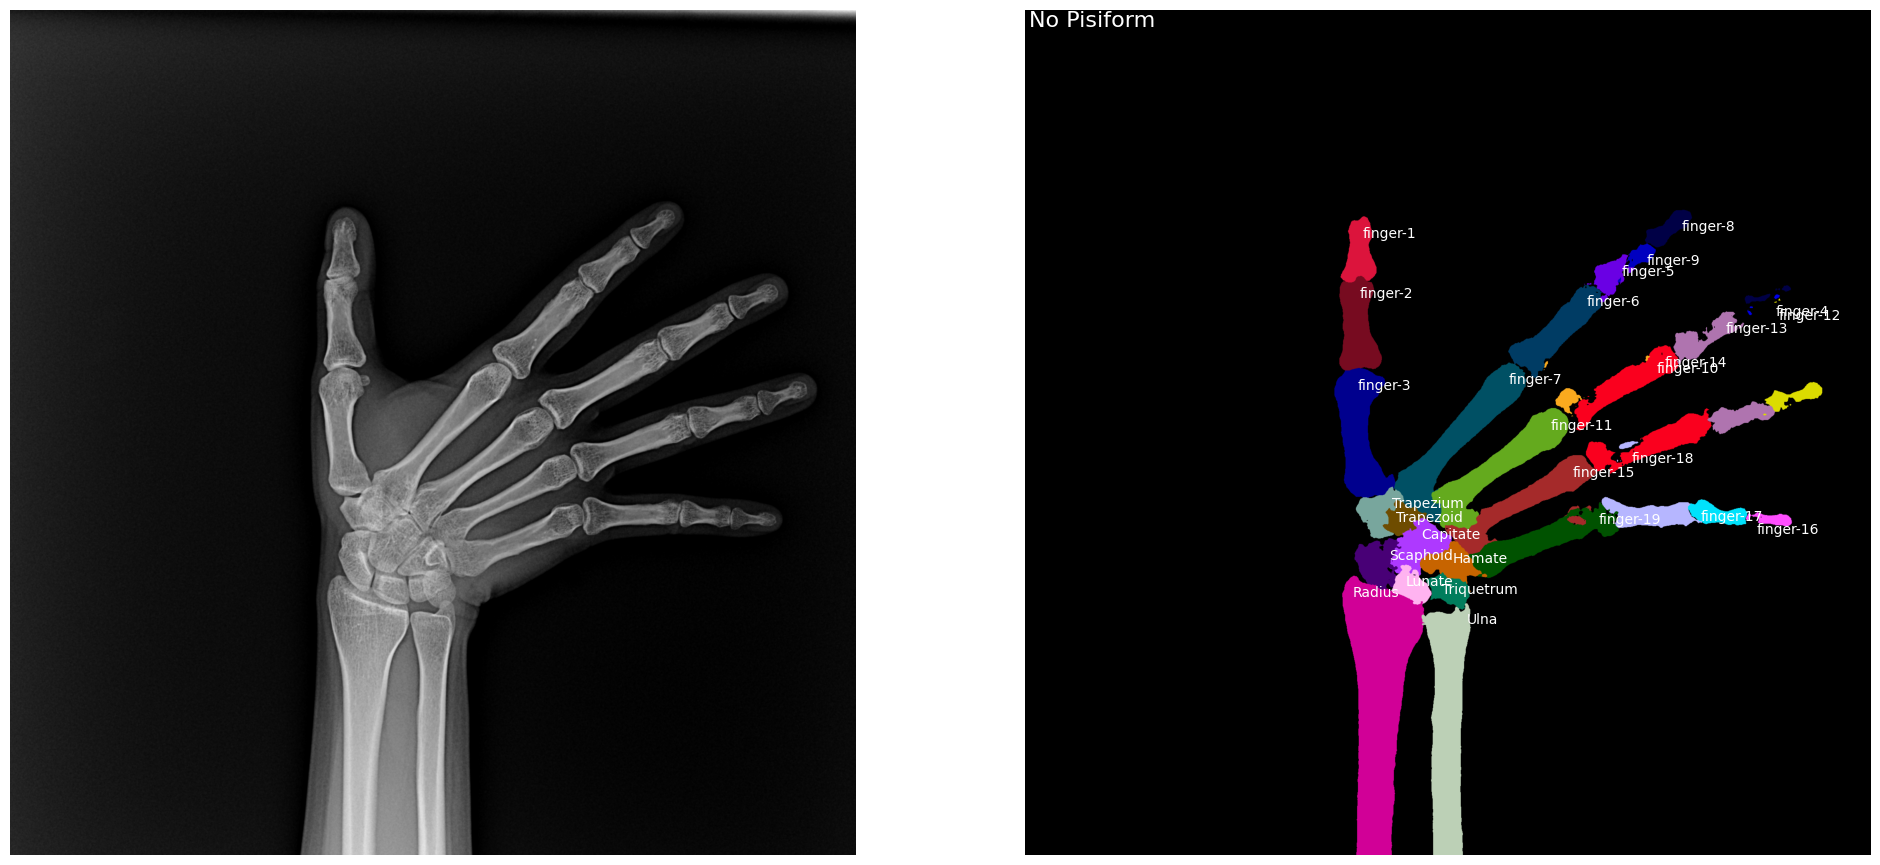

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    
ax[0].axis('off')
ax[1].imshow(label2rgb(preds))
ax[1].axis('off')

for i in range(len(nandf)):
    ax[1].text(10, 40*(i+1), 'No '+nanlist[i], fontsize=16, c='white')

for i in range(len(this)):
    ax[1].text(text_coord(float(this['rle'].iloc[i].split()[0]))[0], text_coord(float(this['rle'].iloc[i].split()[0]))[1]+50, this['class'].iloc[i], color='white', fontsize=10)

plt.show()